In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd

# from agrifoodpy.land.land import ALC_1000 as ALC, CEH_1000 as CEH

In [2]:
border_file = 'temporary_data/bdline_gb.gpkg'

countries = gpd.read_file(border_file, layer='country_region')
countries[countries["Name"] == "England"]

england = countries.iloc[[762]]
england

,Name,Area_Code,Area_Description,File_Name,Feature_Serial_Number,Collection_Serial_Number,Global_Polygon_ID,Admin_Unit_ID,Census_Code,Hectares,Non_Inland_Area,Area_Type_Code,Area_Type_Description,Non_Area_Type_Code,Non_Area_Type_Description,geometry
762,England,CY,Country,ENGLAND_COUNTRY,736,736,124433,41428,E92000001,159467.228,2129.716,AA,CIVIL ADMINISTRATION AREA,None,None,"MULTIPOLYGON (((84014.170 5445.450, 84021.580 ..."


In [3]:
# ALC = xr.open_dataset("temporary_data/ALC_100_yorkshire.nc")
# CEH = xr.open_dataset("temporary_data/CEH_100_yorkshire.nc")

scale = 5000

ALC = xr.open_dataset(f"temporary_data/ALC_{scale}_england.nc")
CEH = xr.open_dataset(f"temporary_data/CEH_{scale}_england.nc")

We want to find the area of different crops in the different land classification grades
This should result in a matrix of dimensions (n_crops, n_grades) with values expressed in hectares

In [4]:
crops = CEH.sel(Year=2021)
crops

<xarray.Dataset>
Dimensions:  (Type: 15, x: 115, y: 131)
Coordinates:
  * x        (x) float64 8.514e+04 9.012e+04 9.511e+04 ... 6.485e+05 6.535e+05
  * y        (y) float64 7.823e+03 1.28e+04 1.778e+04 ... 6.501e+05 6.551e+05
    Year     int64 2021
  * Type     (Type) object 'be' 'fb' 'gr' 'ma' 'or' ... 'so' 'sw' 'wb' 'wo' 'ww'
Data variables:
    area     (Type, x, y) float32 ...

In [5]:
types = crops.Type.values
grades = np.arange(1,6)

arable = np.array(types != "gr")
livestock = np.array(types == "gr")

In [6]:
types

array(['be', 'fb', 'gr', 'ma', 'or', 'ot', 'pe', 'po', 'sb', 'sl', 'so',
       'sw', 'wb', 'wo', 'ww'], dtype=object)

In [7]:
# This is an array with all the areas for all crop types 
crops_by_grade = [[crops.area.where(ALC.grade==grade).sel(Type=type).sum(dim=("x", "y")).values for type in types] for grade in grades]
crops_by_grade = np.array(crops_by_grade)
crops_by_grade /= 10000

In [8]:
# Total area for each crop type is (across all grades)
print("Area for each crop type:")
for type, area in zip(types, crops_by_grade.sum(axis=0)):
    print(type, area)
    
# while area for each grade type is (across all types)

print("\nArea for each crop grade:")
for grade, area in zip(grades, crops_by_grade.sum(axis=1)):
    print(f"Grade {grade}:", area)

Area for each crop type:
be 90659.79
fb 194106.53
gr 3041852.8
ma 217253.92
or 252965.36
ot 365018.06
pe 71870.73
po 99321.664
sb 467116.12
sl 12924.987
so 91006.734
sw 197552.89
wb 341356.53
wo 51959.027
ww 1378352.6

Area for each crop grade:
Grade 1: 266823.0
Grade 2: 1358733.8
Grade 3: 4112659.0
Grade 4: 944665.4
Grade 5: 190436.89


In [9]:
# Arable land
print("Total arable land in ALC 3 or better: \n", crops_by_grade[:3, arable].sum())
print("Total arable land in all ALC's: \n", crops_by_grade[:, arable].sum())
print("\n")

# Pasture land
print("Total pasture land in ALC 3 or better: \n", crops_by_grade[:3, livestock].sum())
print("Total pasture land in all ALC's: \n", crops_by_grade[:, livestock].sum())
print("\n")

# Total land
print("Total agricultural land in ALC 3 or better: \n", crops_by_grade[:3, :].sum())
print("Total agricultural land in all ALC's: \n", crops_by_grade.sum())


Total arable land in ALC 3 or better: 
 3528926.5
Total arable land in all ALC's: 
 3831464.8


Total pasture land in ALC 3 or better: 
 2209289.0
Total pasture land in all ALC's: 
 3041852.8


Total agricultural land in ALC 3 or better: 
 5738215.0
Total agricultural land in all ALC's: 
 6873317.0


In [10]:
crops_by_grade[:3, arable].sum() / crops_by_grade[:, arable].sum()

0.9210385

In [11]:
crops_by_grade[:3, livestock].sum() / crops_by_grade[:, livestock].sum()

0.72629714

(53975.63850000109, 684660.2315, -27279.51740999967, 690213.6856100045)

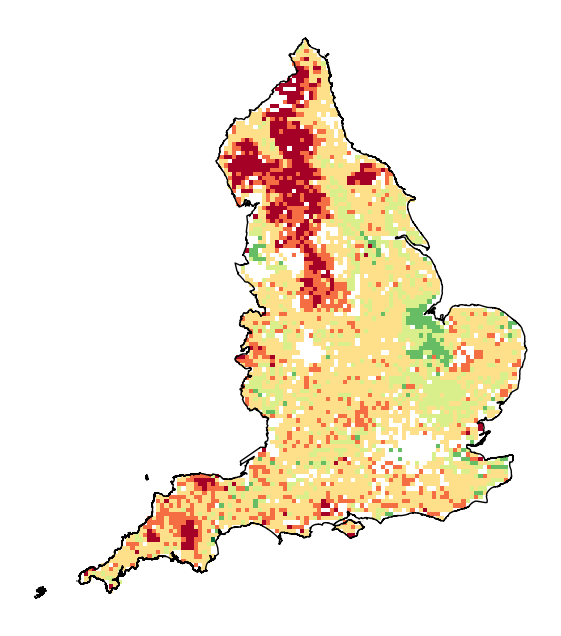

In [12]:
f, ax = plt.subplots(1, 1, figsize=(10,8))

im = ax.imshow(ALC.grade.where(ALC.grade<6).T, origin='lower', interpolation='none', extent=[8.5e4, 6.53e5, 7000, 6.55e5], cmap = "RdYlGn_r")
england.boundary.plot(ax=ax, color = "k", linewidth=1.0)
ax.axis("off")

# plt.imshow(ALC.grade.where(ALC.grade<5).T, origin="lower")

In [13]:
# grass areas

gr = crops.area.sel(Type='gr')

# other areas
other = crops.area.sel(Type=['ww', 'be', 'fb', 'ma', 'or', 'ot', 'po', 'sb', 'sw', 'wb', 'pe', 'sl', 'so', 'wo'])

# maximum areas for crops on each position 
max_other = other.max(dim="Type")
max_other

<xarray.DataArray 'area' (x: 115, y: 131)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * x        (x) float64 8.514e+04 9.012e+04 9.511e+04 ... 6.485e+05 6.535e+05
  * y        (y) float64 7.823e+03 1.28e+04 1.778e+04 ... 6.501e+05 6.551e+05
    Year     int64 2021

In [14]:
# positions where areas of crops are bigger than grass
pos_gr = np.where(gr > max_other)

# pos_ww = np.where(gr < ww)
# pos_other = np.where((max_other > ww) & (max_other > gr))

# positions where crops are bigger than grass
pos_other = np.where(max_other > gr)

In [15]:
map_gr = np.zeros_like(gr)*np.nan

# For points in which grass is majority
for x, y in zip(pos_gr[0], pos_gr[1]):
    if ALC.grade[x,y] in [4,5]:
        map_gr[x,y] = 1
    elif ALC.grade[x,y] in [1,2,3]:
        map_gr[x,y] = 3    

# for x, y in zip(pos_ww[0], pos_ww[1]):
#     map_ww_gr[x,y] = 1

# For points in which crops are majority    
for x, y in zip(pos_other[0], pos_other[1]):
    if ALC.grade[x,y] in [4,5]:
        map_gr[x,y] = 9
    elif ALC.grade[x,y] in [1,2,3]:
        map_gr[x,y] = 10    
    

values = np.unique(map_gr.ravel())

In [16]:
where_grass_45 = np.where(map_gr == 1)
where_grass_123 = np.where(map_gr == 3)
where_crops_45 = np.where(map_gr == 9)
where_crops_123 = np.where(map_gr == 10)

# From the scale, and an hectare being 10000 square meters

resolution = scale**2 / 10000

grass_45 = len(where_grass_45[0]) * resolution
grass_123 = len(where_grass_123[0]) * resolution
crops_45 = len(where_crops_45[0]) * resolution
crops_123 = len(where_crops_123[0]) * resolution

crop_areas = [grass_45, grass_123, crops_45, crops_123]

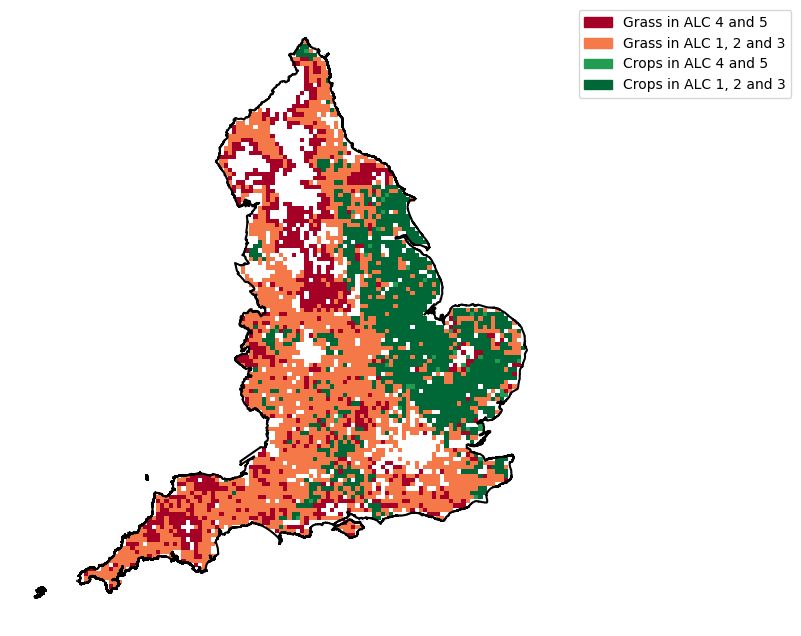

In [17]:
import matplotlib.patches as mpatches
from matplotlib import colors

f, ax = plt.subplots(1, 1, figsize=(10,8))

im = ax.imshow(map_gr.T, origin='lower', interpolation='none', extent=[8.5e4, 6.53e5, 7000, 6.55e5], cmap = "RdYlGn")
england.boundary.plot(ax=ax, color = "k", linewidth=1.5)
ax.axis("off")

labels = ["Grass in ALC 4 and 5", "Grass in ALC 1, 2 and 3", "Crops in ALC 4 and 5", "Crops in ALC 1, 2 and 3"]
colors = [ im.cmap(im.norm(value)) for value in values]
# create a patch (proxy artist) for every color 
patches = [ mpatches.Patch(color=colors[i], label=labels[i] ) for i in range(len(values)-1) ]
# put those patched as legend-handles into the legend
ax.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

# plt.savefig("figures/england_grass_crops.png", transparent=True, dpi=200)

[2210000.0, 5535000.0, 100000.0, 2997500.0]


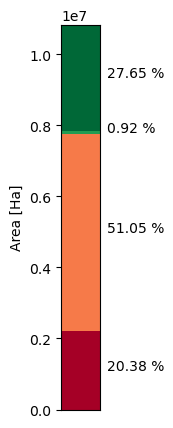

In [18]:
print(crop_areas)

width = 0.3

plt.figure(figsize=(0.5,5))

for ic, crop in enumerate(crop_areas):
    plt.bar(0, crop, bottom = np.sum(crop_areas[:ic]), width=width, color=colors[ic])
    plt.text(0.2, np.sum(crop_areas[:ic]) + crop_areas[ic]/2, '{:.2f} %'.format(100 * crop_areas[ic] / np.sum(crop_areas)))
# plt.axis("off")

plt.xticks([])
plt.ylabel("Area [Ha]")
plt.xlim(-width/2,width/2)
plt.ylim(0, np.sum(crop_areas))

plt.savefig("figures/bar_areas_grass.png", dpi=200, transparent=True, bbox_inches = 'tight')